### Working with true values
To debug the issues with the mock data, the goal here is to analyze the "true" values in the mock data to see if the other issues is with sorting out contaminating data (like the $10M_\odot$ bump). If everything works fine here, then that's most likely the issue. If it still doesn't work here, then there's something deeply wrong with our analysis in general and will need to be revamped almost entirely

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy.cosmology import Planck18
from scipy.integrate import quad
from tqdm import tqdm
import warnings
from scipy import integrate
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let's just start by plotting the mock data in full again, so we know what we're looking at

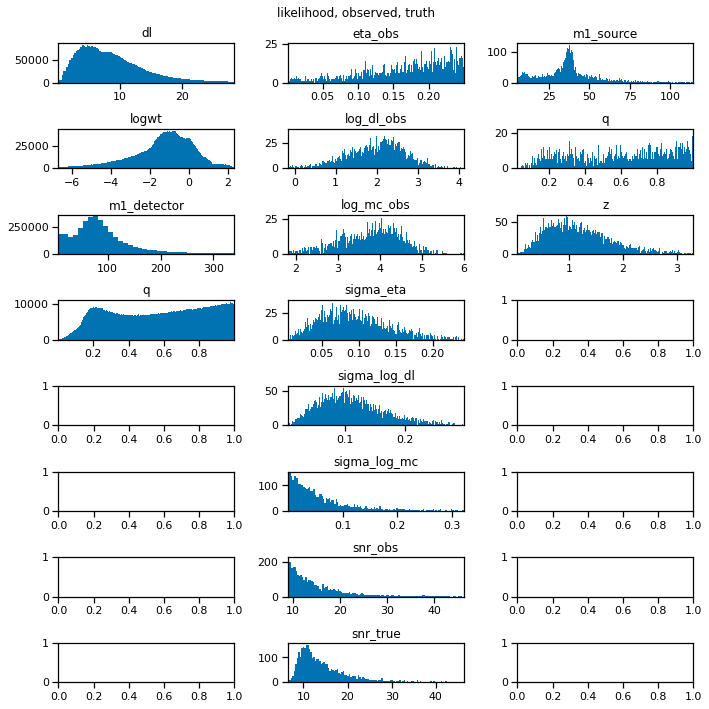

In [2]:
f = "observations.h5"
with h5py.File(f, 'r') as hf:
    keys = list(hf.keys())
    max_len = max([len(list(hf[key])) for key in keys])
    
    fig, axs = subplots(max_len, len(keys), figsize=(10, 10)) #yes I know it's only 3 keys, this keeps it general
    
    for ind_y, key in enumerate(keys):
        params = list(hf[key])
        for ind_x, param in enumerate(params):
            data = array(hf[key][param]).flatten()

            axs[ind_x][ind_y].hist(data, bins=500)
            axs[ind_x][ind_y].set_title(param)
            
            mu = mean(data)
            sigma =std(data)
            up = min(max(data), mu+3*sigma) #upper bound of plot
            low = max(min(data), mu-3*sigma)
            
            axs[ind_x][ind_y].set_xlim(low, up)
    
#     fig.suptitle(sum([str(k) for k in keys]))
    fig.suptitle("likelihood, observed, truth") #This breaks the earlier reason, but the line above didn't work
    fig.tight_layout()


Just going to move some necessary functions in here now from before so they're there when needed:

In [3]:
### Functions for implementing MCMC using PyMC4

def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

def make_model(ms_obs, sigma_ms_obs, dls, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 

        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Bound('h', pm.Lognormal.dist(mu=log(0.7), sigma=0.2), lower=0.35, upper=1.4)
#         h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

def find_argmax_gridsearch(xs, fxs):
    imax = np.argmax(fxs)

    if imax == 0 or imax == len(xs)-1:
        warnings.warn('max occurs at grid boundary')
        return xs[imax]

    x0, x1, x2 = xs[imax-1], xs[imax], xs[imax+1]
    f0, f1, f2 = fxs[imax-1], fxs[imax], fxs[imax+1]

    dx01 = x0-x1
    dx12 = x1-x2
    dx20 = x2-x0

    sx01 = x0+x1
    sx12 = x1+x2
    sx20 = x2+x0

    xmax = (f2*dx01*sx01 + f0*dx12*sx12 + f1*dx20*sx20)/(2*(f2*dx01 + f0*dx12 + f1*dx20))

    return xmax


Now to plot the data and see when the $35M_\odot$ bump actually shows up

/home/tanner/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


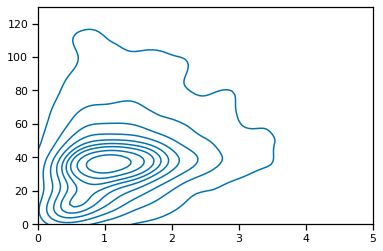

In [4]:
f = "observations.h5"

with h5py.File(f, 'r') as hf:
    ms_true = np.array(hf['truth']['m1_source'])
    zs_true = np.array(hf['truth']['z'])
    
    sns.kdeplot(zs_true, ms_true)
    plt.xlim(0, 5)
    plt.ylim(0, 130)

In [5]:
import matplotlib.colors as mcolors
cmap = list(mcolors.BASE_COLORS.keys())

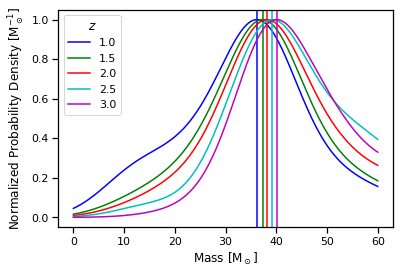

In [7]:
n_z = 5
zmin = 1
zmax = 3
m_max = 60
m_bins = 400
z_slices = np.linspace(zmin, zmax, n_z)
mass_indices = np.linspace(0, m_max, m_bins)

with hf:
    kde = gaussian_kde(np.array([zs_true, ms_true]))
    
    for j, d in enumerate(z_slices):
    
        pdf = [kde.pdf([d, i]) for i in mass_indices]
        ### Dviding by max(pdf) below here to normalize curves
        plt.plot(mass_indices, pdf/max(pdf),c=cmap[j], label=d)
        plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])

    plt.legend(title=r"$z$")
    plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
    plt.ylabel(r"Normalized Probability Density [$\mathrm{M_\odot^{-1}}$]")

After playing around with `zmin` and `zmax` for a bit, it looks like the best range is $1 \leq z \leq 3$

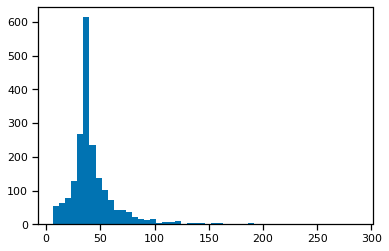

In [8]:
plt.hist(ms_true[(zmin < zs_true) & (zs_true < zmax)], bins=50)
plt.show()

In [20]:
### Sorting out the data that is in the correct redshift range

filtered_ms = ms_true[(zmin < zs_true) & (zs_true < zmax)]
filtered_zs = zs_true[(zmin < zs_true) & (zs_true < zmax)]

print(f'''---------------------------
Original catalog size: %d
Filtered catalog size: %d
---------------------------''' % (len(ms_true), len(filtered_ms)))

print(min(filtered_zs), max(filtered_zs))

---------------------------
Original catalog size: 3643
Filtered catalog size: 2003
---------------------------
1.0000605765948807 2.9980365200134282


In [12]:
n_runs = 5
n_events = len(filtered_ms)
n_zs=10
n_mc = 20
m_min = min(filtered_ms)
m_max = max(filtered_ms)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
z_cent = np.quantile(filtered_zs, np.linspace(0.05, 0.95, n_zs))

ZG, MG = np.meshgrid(z_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_zs))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

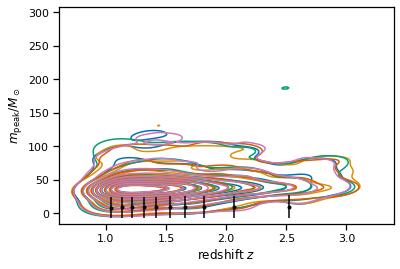

In [17]:
for run in tqdm(range(n_runs)):

    events = np.random.randint(n_events, size=n_events)
    
    m = filtered_ms[events]
    z = filtered_zs[events]
    
    arr = np.array([z, m])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([ZG.ravel(), MG.ravel()])).reshape(ZG.shape)
    for i in range(n_zs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=z, y=m)
    
plt.errorbar(z_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.xlabel(r'redshift $z$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

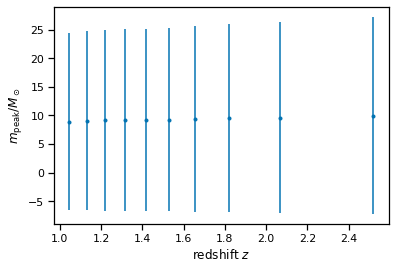

In [15]:
plt.errorbar(z_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.')
plt.xlabel(r'redshift $z$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')